# Face Recognition -Model6

使用MTCNN進行人臉偵測

使用自建CNN模型進行人臉辨識

使用kaggle5位日本明星資料集

進行靜態圖像辨識

In [24]:
# 將警告訊息關掉
import warnings
warnings.filterwarnings('ignore')

#Utilities相關函式庫
import os
import sys

# 圖像處理函示庫
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

# 數值處理函式庫
import pandas as pd
import numpy as np

# 機器學習函式庫
from sklearn.model_selection import train_test_split

# 深度學習函式庫
import keras 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, concatenate,Input
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import RMSprop, Adam, SGD
from keras.utils import np_utils
from keras import regularizers
from keras import initializers
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

# Backend
from keras import backend as K

# 人臉偵測函式庫
from mtcnn import MTCNN
detector = MTCNN()

# 相關參數設定
picture_size = 224
batch_size = 8  # 一次用多少筆資料更新模型
num_classes = 5  # 資料集有幾個類別
epochs = 300      # 訓練迭代次數
save_dir = os.path.join(os.getcwd(), 'saved_models') # 儲存模型的路徑
model_name = 'Model6_InceptionV4_V1, trained_model.h5' # 模型名稱


In [25]:
# 直接讀取處理好的檔案
total_img_resized = np.load('total_crop_resized.npy')
labelnames = np.load('labelnames.npy')
total_img_resized.shape

(448, 224, 224, 3)

In [26]:
# 切分訓練/測試資料
#train_x = total_img
#train_y = labelnames

train_x,test_x, train_y, test_y = train_test_split(total_img_resized,
                                                  labelnames,
                                                test_size = 0.1,stratify= labelnames)#random_state = 123,
print('train:',train_x.shape,'test:',test_x.shape)

# 正規化資料
# 標準化0~255的值到0~1
x_train_normalize = train_x.astype('float32') / 255.0
x_test_normalize = test_x.astype('float32') / 255.0

train: (403, 224, 224, 3) test: (45, 224, 224, 3)


In [28]:
# GoogLeNet-Inception-V4
# WEIGHTS_PATH = 'https://github.com/kentsommer/keras-inceptionV4/releases/download/2.1/inception-v4_weights_tf_dim_ordering_tf_kernels.h5'
# WEIGHTS_PATH_NO_TOP = 'https://github.com/kentsommer/keras-inceptionV4/releases/download/2.1/inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5'
def conv2d_bn(x, nb_filter, num_row, num_col,
              padding='same', strides=(1, 1), use_bias=False):
    """
    Utility function to apply conv + BN. 
    (Slightly modified from https://github.com/fchollet/keras/blob/master/keras/applications/inception_v3.py)
    """
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    x = Conv2D(nb_filter, (num_row, num_col),
                      strides=strides,
                      padding=padding,
                      use_bias=use_bias,
                      kernel_regularizer=regularizers.l2(0.00004),
                      kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(x)
    x = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(x)
    x = Activation('relu')(x)
    return x


def block_inception_a(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 96, 1, 1)

    branch_1 = conv2d_bn(input, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3)

    branch_2 = conv2d_bn(input, 64, 1, 1)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)

    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 96, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def block_reduction_a(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 384, 3, 3, strides=(2,2), padding='valid')

    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 3, 3)
    branch_1 = conv2d_bn(branch_1, 256, 3, 3, strides=(2,2), padding='valid')

    branch_2 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(input)

    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x


def block_inception_b(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 384, 1, 1)

    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 1, 7)
    branch_1 = conv2d_bn(branch_1, 256, 7, 1)

    branch_2 = conv2d_bn(input, 192, 1, 1)
    branch_2 = conv2d_bn(branch_2, 192, 7, 1)
    branch_2 = conv2d_bn(branch_2, 224, 1, 7)
    branch_2 = conv2d_bn(branch_2, 224, 7, 1)
    branch_2 = conv2d_bn(branch_2, 256, 1, 7)

    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 128, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def block_reduction_b(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 192, 1, 1)
    branch_0 = conv2d_bn(branch_0, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_1 = conv2d_bn(input, 256, 1, 1)
    branch_1 = conv2d_bn(branch_1, 256, 1, 7)
    branch_1 = conv2d_bn(branch_1, 320, 7, 1)
    branch_1 = conv2d_bn(branch_1, 320, 3, 3, strides=(2,2), padding='valid')

    branch_2 = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(input)

    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x


def block_inception_c(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 256, 1, 1)

    branch_1 = conv2d_bn(input, 384, 1, 1)
    branch_10 = conv2d_bn(branch_1, 256, 1, 3)
    branch_11 = conv2d_bn(branch_1, 256, 3, 1)
    branch_1 = concatenate([branch_10, branch_11], axis=channel_axis)


    branch_2 = conv2d_bn(input, 384, 1, 1)
    branch_2 = conv2d_bn(branch_2, 448, 3, 1)
    branch_2 = conv2d_bn(branch_2, 512, 1, 3)
    branch_20 = conv2d_bn(branch_2, 256, 1, 3)
    branch_21 = conv2d_bn(branch_2, 256, 3, 1)
    branch_2 = concatenate([branch_20, branch_21], axis=channel_axis)

    branch_3 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 256, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def inception_v4_base(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    # Input Shape is 299 x 299 x 3 (th) or 3 x 299 x 299 (th)
    net = conv2d_bn(input, 32, 3, 3, strides=(2,2), padding='valid')
    net = conv2d_bn(net, 32, 3, 3, padding='valid')
    net = conv2d_bn(net, 64, 3, 3)

    branch_0 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)

    branch_1 = conv2d_bn(net, 96, 3, 3, strides=(2,2), padding='valid')

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    branch_0 = conv2d_bn(net, 64, 1, 1)
    branch_0 = conv2d_bn(branch_0, 96, 3, 3, padding='valid')

    branch_1 = conv2d_bn(net, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 64, 1, 7)
    branch_1 = conv2d_bn(branch_1, 64, 7, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3, padding='valid')

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    branch_0 = conv2d_bn(net, 192, 3, 3, strides=(2,2), padding='valid')
    branch_1 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    # 35 x 35 x 384
    # 4 x Inception-A blocks
    for idx in range(4):
    	net = block_inception_a(net)

    # 35 x 35 x 384
    # Reduction-A block
    net = block_reduction_a(net)

    # 17 x 17 x 1024
    # 7 x Inception-B blocks
    for idx in range(7):
    	net = block_inception_b(net)

    # 17 x 17 x 1024
    # Reduction-B block
    net = block_reduction_b(net)

    # 8 x 8 x 1536
    # 3 x Inception-C blocks
    for idx in range(3):
    	net = block_inception_c(net)

    return net


def inception_v4(num_classes, dropout_keep_prob, weights, include_top):
    '''
    Creates the inception v4 network
    Args:
    	num_classes: number of classes
    	dropout_keep_prob: float, the fraction to keep before final layer.
    
    Returns: 
    	logits: the logits outputs of the model.
    '''

    # Input Shape is 299 x 299 x 3 (tf) or 3 x 299 x 299 (th)
    if K.image_data_format() == 'channels_first':
        inputs = Input((3, 299, 299))
    else:
        inputs = Input((299, 299, 3))

    # Make inception base
    x = inception_v4_base(inputs)


    # Final pooling and prediction
    if include_top:
        # 1 x 1 x 1536
        x = AveragePooling2D((8,8), padding='valid')(x)
        x = Dropout(dropout_keep_prob)(x)
        x = Flatten()(x)
        # 1536
        x = Dense(units=num_classes, activation='softmax')(x)

    model = Model(inputs, x, name='inception_v4')

    # load weights
    if weights == 'imagenet':
        if K.image_data_format() == 'channels_first':
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
        if include_top:
            weights_path = get_file(
                'inception-v4_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='9fe79d77f793fe874470d84ca6ba4a3b')
        else:
            weights_path = get_file(
                'inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='9296b46b5971573064d12e4669110969')
        model.load_weights(weights_path, by_name=True)
    return model


def create_model(num_classes=5, dropout_prob=0.2, weights=None, include_top=False):
    return inception_v4(num_classes, dropout_prob, weights, include_top)


model = create()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_697 (Conv2D)             (None, 111, 111, 32) 864         input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_673 (BatchN (None, 111, 111, 32) 128         conv2d_697[0][0]                 
__________________________________________________________________________________________________
activation_673 (Activation)     (None, 111, 111, 32) 0           batch_normalization_673[0][0]    
__________________________________________________________________________________________________
conv2d_698

In [29]:
# 訓練模型
optimizer = Adam(lr=3e-6,decay=0.0001,beta_1=0.99,beta_2=0.999) #100e-6
model.compile(loss = 'categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])

In [30]:
# Data Augmentation
datagen  = ImageDataGenerator(
            rotation_range = 30,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            horizontal_flip = True, 
            vertical_flip = False,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest')

In [31]:
# Use ModelCheckpoint to save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, verbose = 1)

earlystop = EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 1) # patience=10為連續10次模型loss沒再下降就停止

# Fit model
aug_ratio = 2
steps_per_epoch = int(aug_ratio * train_x.shape[0] / batch_size)
validation_steps = int(aug_ratio * test_x.shape[0] / batch_size)

model_history = model.fit_generator(datagen.flow(x_train_normalize, train_y, batch_size = batch_size),
                                   epochs = epochs,
                                   validation_data = (x_test_normalize, test_y),
                                   callbacks = [checkpoint, earlystop],
                                   steps_per_epoch=steps_per_epoch,
                                   validation_steps=validation_steps
                                   )

Epoch 1/300
100/100 [==============================] - 53s 530ms/step - loss: 4.1420 - acc: 0.2263 - val_loss: 4.6109 - val_acc: 0.2667

Epoch 00001: val_loss improved from inf to 4.61092, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model6_InceptionV4_V1, trained_model.h5
Epoch 2/300
100/100 [==============================] - 15s 153ms/step - loss: 4.0837 - acc: 0.2463 - val_loss: 4.7221 - val_acc: 0.2444

Epoch 00002: val_loss did not improve from 4.61092
Epoch 3/300
100/100 [==============================] - 15s 153ms/step - loss: 4.0733 - acc: 0.2558 - val_loss: 4.9979 - val_acc: 0.2889

Epoch 00003: val_loss did not improve from 4.61092
Epoch 4/300
100/100 [==============================] - 15s 153ms/step - loss: 4.0950 - acc: 0.2854 - val_loss: 4.5728 - val_acc: 0.3111

Epoch 00004: val_loss improved from 4.61092 to 4.57280, saving model to C:\Users\foresight\Desktop\AI\Face Recognition\saved_models\Model6_InceptionV4_V1, trained_model.h5
Epoch 5/30

In [26]:
# loading save model
print('Loading trained model')
model_path = os.path.join(save_dir, model_name)
model = load_model(model_path)

# Score trained model
scores = model.evaluate(x_test_normalize, test_y, verbose = 1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Loading trained model
45/45 [==============================] - 2s 34ms/step
Test loss: 0.9972473343213399
Test accuracy: 0.6222222288449605


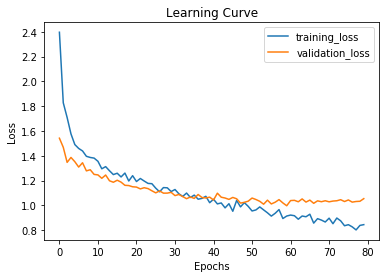

In [27]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()